In [1]:
%matplotlib inline
import seaborn as sns
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib
import matplotlib.ticker as mticker
import numpy as np
from io import StringIO
pd.__version__

'0.25.3'

In [2]:
#This is the old colormap
#colors=((0.8941176470588236, 0.10196078431372549, 0.10980392156862745), (0.21568627450980393, 0.49411764705882355, 0.7215686274509804), (0.30196078431372547, 0.6862745098039216, 0.2901960784313726), (0.596078431372549, 0.3058823529411765, 0.6392156862745098), (1.0, 0.4980392156862745, 0.0), (1.0, 1.0, 0.2), (0.6509803921568628, 0.33725490196078434, 0.1568627450980392), (0.9686274509803922, 0.5058823529411764, 0.7490196078431373))
colors = sns.color_palette()[:8]
names=('FairShare','FCFS','GreedyCom','Set-10','PeriodicGreedyYield','GreedyYield','LookAheadGreedyYield','BestNextEvent')
labels=("fairShare","FCFS","greedyCom","Set10Learn","fixedWindow","greedyYield","lookAheadGreedyYield","nextEvLexMin")
hue_order=("fairShare","FCFS","Set10Learn","greedyYield","greedyCom","lookAheadGreedyYield","fixedWindow","nextEvLexMin")
methodColor = dict(zip(labels, colors))
methodName = dict(zip(labels, names))

In [3]:
field_name_and_types = {'plat': str, 'nodef': float, 'coref': float, 'memf': float, 'nodebwf': float, 'sysbwf': float,
                        'run': int, 'method': str, 'version': str, 'iopressure': float, 'minyield': float,
                        'efficiency': float, 'utilization': float}
types = tuple(field_name_and_types.values())
names = tuple(field_name_and_types.keys())
n = len(types)
r = range(n)
ln = 0
cleanCSV = str()
CSVerrors = str()
nberr = 0
errlines = 0
with open('all.csv', 'r') as f:
    while True:
        line = f.readline()
        ln += 1
        if not line:
            break
        if 1 == ln:
            cleanCSV += line
            continue
        elts = line.rstrip().split(',')
        err = False
        for k in r:
            t = types[k]
            try:
                x = t(elts[k])
            except ValueError:
                if not err:
                    errlines += 1
                err = True
                nberr += 1
                CSVerrors += f"Error at line {ln}: field {names[k]} value '{elts[k]}' is not an {repr(t)}\n"
        if not err:
            cleanCSV += line
print(f"There was {nberr} errors over {errlines} lines in the source file.")
csvlen = cleanCSV.count('\n')
print(f"cleanCSV is {csvlen-1} records long")
cleanCSV = StringIO(cleanCSV)
all = pd.read_csv(cleanCSV, dtype = field_name_and_types, error_bad_lines = False )
cleanCSV.close()

There was 0 errors over 0 lines in the source file.
cleanCSV is 574991 records long


In [4]:
CSVerrors

''

In [5]:
all['MinYield(method)/MinYield(fairShare)'] = all['minyield']
for c, r in all.groupby(['plat', 'nodef', 'coref', 'memf', 'nodebwf', 'sysbwf', 'run', 'version']):
    fs=r[r.method == 'fairShare']['minyield']
    if fs is None or len(fs) == 0:
        all.loc[r.index, 'MinYield(method)/MinYield(fairShare)'] = None
        continue
    if not isinstance(fs, float):
        fs = fs.iloc[0]
    all.loc[r.index, 'MinYield(method)/MinYield(fairShare)'] = r['MinYield(method)/MinYield(fairShare)']/float(fs)

In [6]:
all['Machine'] = None
machines_nodef = sorted(all['nodef'].unique())
machines_names = ["$M_{" + str(m) + "}$" for m in range(len(machines_nodef))]
machines_names[0] = 'Celio'
print(machines_names)
for c, r in all.groupby(['nodef']):
    i = machines_nodef.index(c)
    if i >= 10:
        i = 10
    all.loc[r.index, 'Machine'] = machines_names[i]

['Celio', '$M_{1}$', '$M_{2}$', '$M_{3}$', '$M_{4}$', '$M_{5}$', '$M_{6}$', '$M_{7}$', '$M_{8}$', '$M_{9}$', '$M_{10}$', '$M_{11}$', '$M_{12}$']


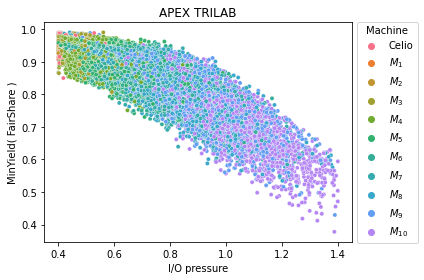

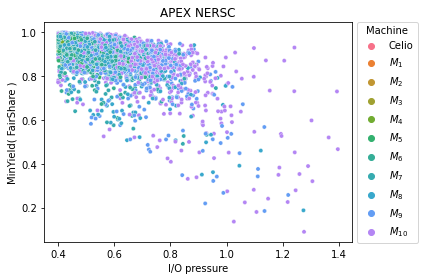

In [7]:
for plat in ["trilab", "nersc"]:
    basis = all[ ((all.method == "fairShare")&(all.version == 'v1')&(all.plat==plat)) ]
    d = basis[((basis.iopressure >= 0.4)&(basis.iopressure <= 1.4))]
    plt.figure()
    ax = sns.scatterplot(data=d, x='iopressure', y='minyield', size=.1, 
                         hue='Machine', hue_order = machines_names)
    #print(ax.get_children()[0].get_fc())
    #ax = sns.kdeplot(data=d, x='iopressure', y='minyield', fill=False, ax=ax, legend=False)
    ax.set(xlabel='I/O pressure',
           ylabel='MinYield( FairShare )',
           title=f'APEX {plat.upper()}')
    h,l = ax.get_legend_handles_labels()
    plt.legend(h[0:11], l[0:11], title='Machine', loc='center left', bbox_to_anchor=(1, 0.5))
    plt.tight_layout()
    plt.savefig(f"APEX-{plat.upper()}-MinYield-fairShare.png", dpi=150)

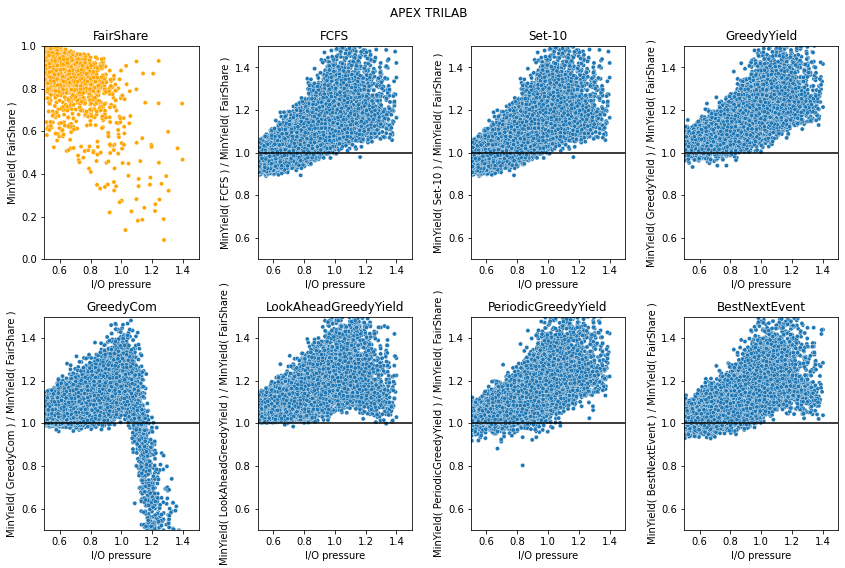

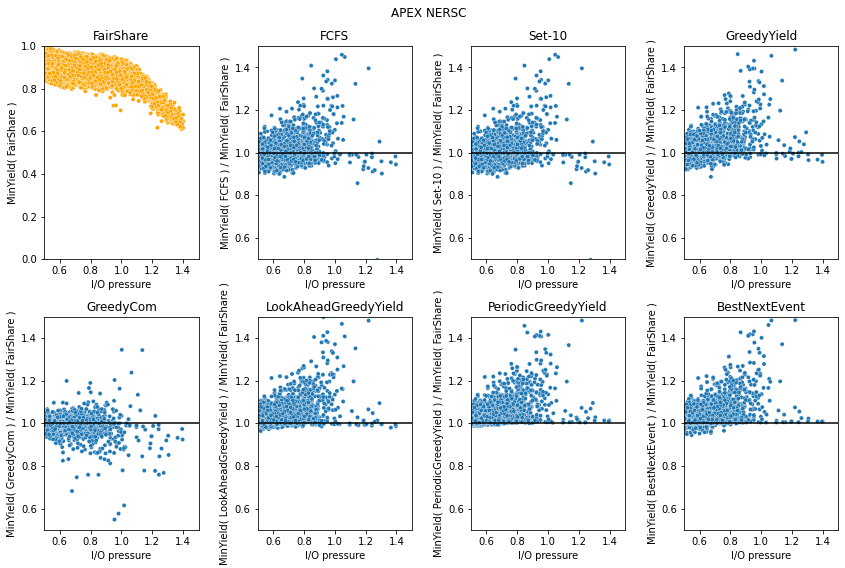

In [8]:
for plat in ["trilab", "nersc"]:
    fig,axes = plt.subplots(2, 4)
    fig.set_size_inches(12, 8)
    methods = sorted(list(methodName.keys()))
    for idx, n in enumerate(hue_order):
        i = int(idx / 4)
        j = idx % 4
        if n != 'fairShare':
            d = all[((all.plat==plat)&(all.version=='v1')&(all.iopressure >= 0.5)&(all.iopressure <= 1.4)&(all.method == n))]
            ax = sns.scatterplot(data=d, x='iopressure', y='MinYield(method)/MinYield(fairShare)', size=.1, legend=False, ax=axes[i,j])
            ax.set_ylim([0.5, 1.5])
            ax.axhline(y=1, color='black')
            ax.set(xlabel='I/O pressure', ylabel='MinYield( '+methodName[n]+' ) / MinYield( FairShare )', title=methodName[n])
        else:
            ax = sns.scatterplot(data=d, x='iopressure', y='minyield', size=.1, ax=axes[i,j], 
                                 color='orange', legend=False)
            ax.set_ylim([0, 1])
            ax.set(xlabel='I/O pressure', ylabel='MinYield( FairShare )', title=methodName[n])
        ax.set_xlim([0.5,1.5])
    fig.suptitle(f"APEX {plat.upper()}")
    plt.tight_layout()
    plt.savefig(f"APEX-{plat.upper()}-MinYield-method.png", dpi=150)

In [9]:
if 'biniop' in all.columns:
    all = all.drop(columns=['biniop'])
all.insert(len(all.columns), 'biniop', all.iopressure.apply(lambda x: np.floor(x*25.0)/25.0))
all['biniop'] = all['biniop'].astype(float)
print(all['biniop'].unique())
print(all['method'].unique())

[0.2  0.32 0.28 0.16 0.44 0.12 0.68 0.04 0.24 0.08 0.36 0.6  0.52 0.4
 1.04 0.48 0.64 0.96 0.56 0.76 1.24 0.88 0.8  0.84 0.   0.92 0.72 1.
 1.4  1.28 1.12 1.56 1.2  1.08 1.16 1.36 1.76 1.44 1.32 1.48 1.68 1.72
 1.52 1.64 2.   1.92 2.12 1.88 1.96 2.16 2.04 2.08 1.6 ]
['fairShare' 'FCFS' 'greedyYield' 'greedyCom' 'fixedWindow'
 'lookAheadGreedyYield' 'nextEvLexMin' 'Set10Learn']


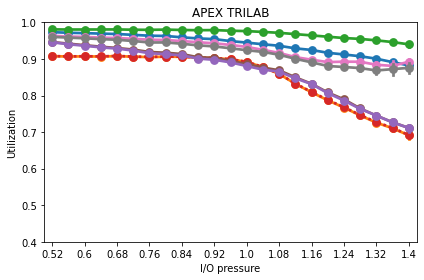

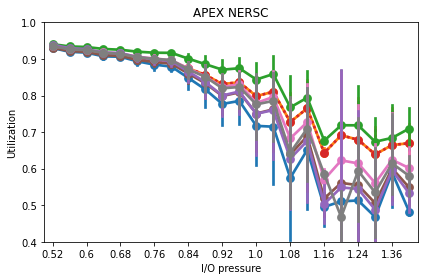

In [25]:
for plat in ["trilab", "nersc"]:
    plt.figure()
    d = all[((all.plat==plat)&(all.version=='v1')&(all.biniop >= 0.5)&(all.biniop <= 1.4))]
    ax = sns.pointplot(data=d, x='biniop', y='utilization', hue='method',
                       hue_order = hue_order,
                       palette=methodColor)
    lines = ax.get_lines()
    Set10Learn_color = methodColor['Set10Learn']
    for l in lines:
        if l.get_color() == Set10Learn_color:
            l.set_dashes([1,1])
    ax.xaxis.set_major_locator(mticker.MultipleLocator(2))
    ax.set_ylim([0.4, 1])
    ax.set(xlabel='I/O pressure', ylabel='Utilization', title=f"APEX {plat.upper()}")
    ax.legend([], [], frameon=False)
    #for t in ax.legend().get_texts():
    #    t.set_text( methodName[t.get_text()] )
    plt.tight_layout()
    plt.savefig(f"APEX-{plat.upper()}-utilization-method.png", dpi=150)

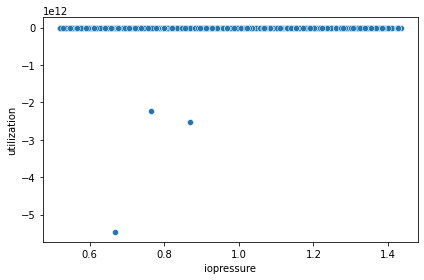

In [29]:
d = all[((all.plat=='trilab')&(all.version=='v1')&(all.biniop >= 0.5)&(all.biniop <= 1.4))]
ax=sns.scatterplot(data=d[d['method']=='fixedWindow'], x='iopressure', y='utilization')
plt.tight_layout()

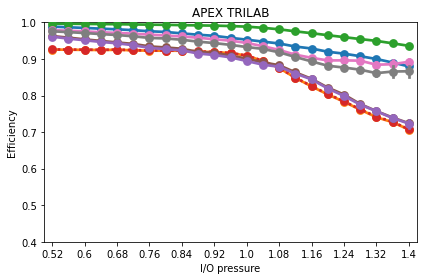

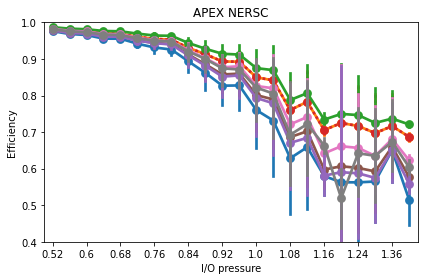

In [26]:
for plat in ["trilab", "nersc"]:
    plt.figure()
    d = all[((all.plat==plat)&(all.version=='v1')&(all.biniop >= 0.5)&(all.biniop <= 1.4))]
    ax = sns.pointplot(data=d, x='biniop', y='efficiency', hue='method',
                       hue_order = hue_order,
                       palette=methodColor)
    lines = ax.get_lines()
    Set10Learn_color = methodColor['Set10Learn']
    for l in lines:
        if l.get_color() == Set10Learn_color:
            l.set_dashes([1,1])
    ax.xaxis.set_major_locator(mticker.MultipleLocator(2))
    ax.set_ylim([0.4, 1])
    ax.set(xlabel='I/O pressure', ylabel='Efficiency', title=f"APEX {plat.upper()}")
    ax.legend([], [], frameon=False)
    #for t in ax.legend().get_texts():
    #    t.set_text( methodName[t.get_text()] )
    plt.tight_layout()
    plt.savefig(f"APEX-{plat.upper()}-efficiency-method.png", dpi=150)

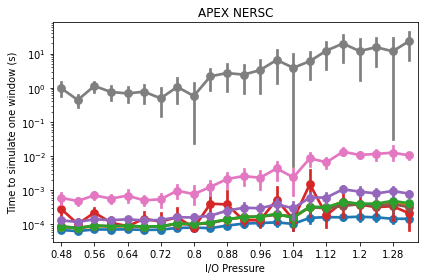

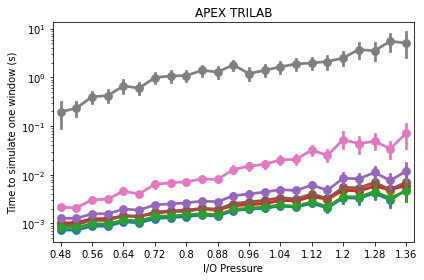

In [28]:
fields = {'plat': str, 'machine': float, 'method': str, 'version': str, 'iopressure': float, 'time': float }
t=pd.read_csv('timing.csv', dtype = fields)
t.insert(len(t.columns), 'biniop', t.iopressure.apply(lambda x: np.floor(x*25.0)/25.0))
t['biniop'] = t['biniop'].astype(float)

for plat in ["nersc", "trilab"]:
    fig = plt.figure()
    ax = sns.pointplot(data=t[((t.plat == plat)&(t.iopressure>=0.5)&(t.iopressure<=1.4))], 
                       x='biniop', y='time', hue='method',
                       hue_order=hue_order,
                       palette=methodColor)
    ax.set(xlabel='I/O Pressure',
           ylabel='Time to simulate one window (s)',
           title=f'APEX {plat.upper()}')
    ax.xaxis.set_major_locator(mticker.MultipleLocator(2))
    ax.legend([], [], frameon=False)
#    for f in ax.legend().get_texts():
#        f.set_text( methodName[f.get_text()] )
    plt.yscale('log')
    plt.tight_layout()
    plt.savefig(f"APEX-{plat.upper()}-Simulation-Time.png", dpi=150)

In [13]:
fields = {'plat': str, 'fnode': float, 'nbApps': int, 'nbNodes': int, 'usage': float, 'windur': float }
t=pd.read_csv('windows.csv', dtype = fields)
t['Machine'] = None
machines_nodef = sorted(t['fnode'].unique())
machines_names = ["$M_{" + str(m) + "}$" for m in range(len(machines_nodef))]
machines_names[0] = 'Celio'
print(machines_names)
for c, r in t.groupby(['fnode']):
    i = machines_nodef.index(c)
    if i >= 10:
        i = 10
    t.loc[r.index, 'Machine'] = machines_names[i]

['Celio', '$M_{1}$', '$M_{2}$', '$M_{3}$', '$M_{4}$', '$M_{5}$', '$M_{6}$', '$M_{7}$', '$M_{8}$', '$M_{9}$', '$M_{10}$', '$M_{11}$', '$M_{12}$']


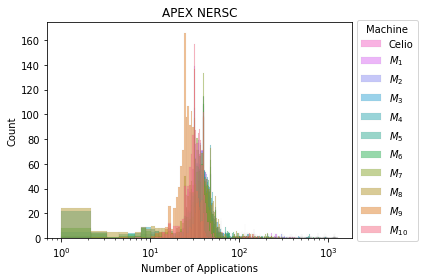

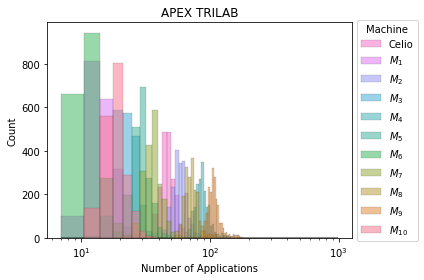

In [14]:
for plat in ["nersc", "trilab"]:
    plt.figure()
    ax = sns.histplot(data=t[t.plat == plat], x='nbApps', hue='Machine', 
                      stat='count')
    ax.set(xlabel='Number of Applications',
           ylabel='Count',
           title=f'APEX {plat.upper()}')
    plt.legend(title='Machine', loc='center left', bbox_to_anchor=(1, 0.5), 
               labels=machines_names)
    plt.xscale('log')
    plt.tight_layout()
    plt.savefig(f"APEX-{plat.upper()}-WindowsNbApps-Distribution.png", dpi=150)

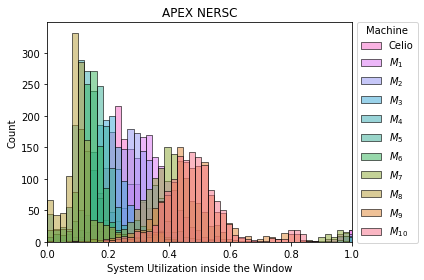

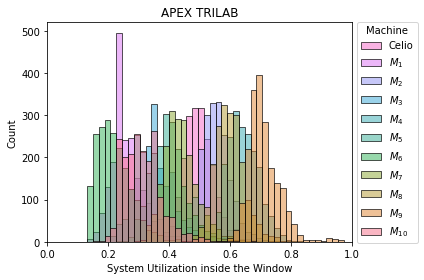

In [15]:
for plat in ["nersc", "trilab"]:
    plt.figure()
    ax = sns.histplot(data=t[t.plat == plat], x='usage', hue='Machine', 
                      stat='count')
    ax.set(xlabel='System Utilization inside the Window',
           ylabel='Count',
           title=f'APEX {plat.upper()}')
    ax.set_xlim([0, 1])
    plt.legend(title='Machine', loc='center left', bbox_to_anchor=(1, 0.5), 
               labels=machines_names)
    plt.tight_layout()
    plt.savefig(f"APEX-{plat.upper()}-WindowUsage-Distribution.png", dpi=150)

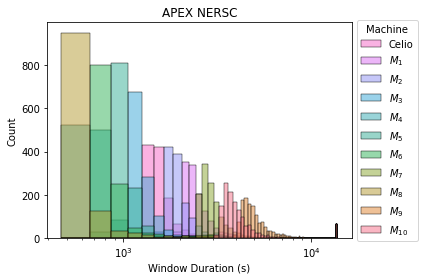

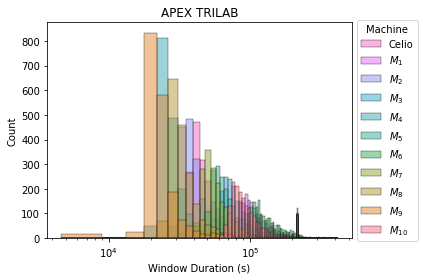

In [16]:
for plat in ["nersc", "trilab"]:
    plt.figure()
    ax = sns.histplot(data=t[t.plat == plat], x='windur', hue='Machine', 
                      stat='count')
    ax.set(xlabel='Window Duration (s)',
           ylabel='Count',
           title=f'APEX {plat.upper()}')
    plt.legend(title='Machine', loc='center left', bbox_to_anchor=(1, 0.5), 
               labels=machines_names)
    plt.xscale('log')
    plt.tight_layout()
    plt.savefig(f"APEX-{plat.upper()}-WindowDuration-Distribution.png", dpi=150)